In [1]:
# Import Dependencies

#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Read in API as df
import pandas_datareader.data as web

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
# Import the dataset into a Pandas Dataframe
# Choose whichever ticker you desire that is listed on the yahoo finance exchange

name=input("Enter Forex Ticker").upper()

df = web.DataReader(name, 'yahoo', start='2000-01-01')

# Review the DataFrame
df

Enter Forex Ticker tsla


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-11-07,208.899994,196.660004,208.649994,197.080002,93916500.0,197.080002
2022-11-08,195.199997,186.750000,194.020004,191.300003,128803400.0,191.300003
2022-11-09,195.889999,177.119995,190.779999,177.589996,127062700.0,177.589996


In [3]:
# Check for missing values in the dataset
df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

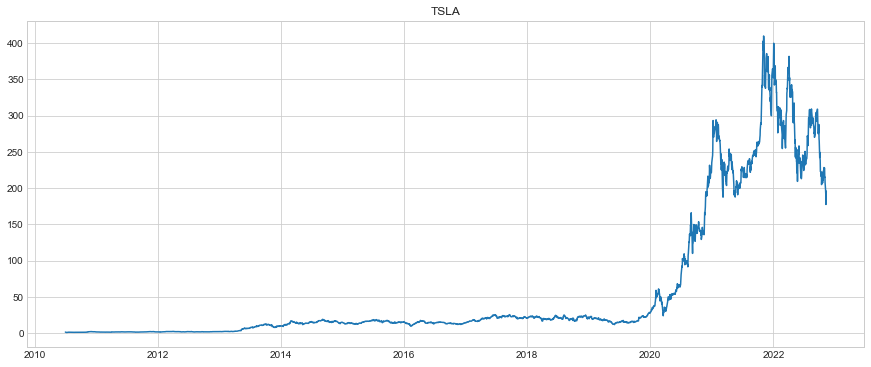

In [4]:
# Visualize the assets closing price

plt.figure(figsize=(15,6))
plt.plot(df['Close'])
plt.title(f"{name}")
plt.show();

<AxesSubplot:>

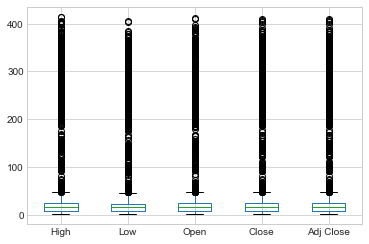

In [5]:
#box plot for Open, High, Low , Close
df.drop('Volume', axis=1).boxplot()

In [6]:
#removing outliers above
vol_cut_off = df.Volume.std()*3 + df.Volume.mean()
df.Volume[df.Volume > vol_cut_off] = vol_cut_off

In [7]:
#removing ouliers beLow
vol_cut_off =  df.Volume.mean() - df.Volume.std()*3
df.Volume[df.Volume < vol_cut_off] = vol_cut_off

<AxesSubplot:>

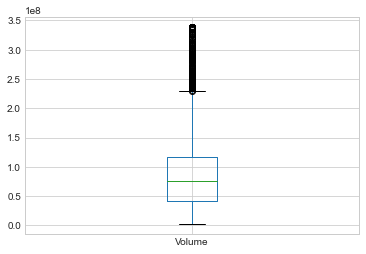

In [8]:
#boxplot for Volume
df[['Volume']].boxplot()

In [33]:
# Create a function to generate custom features

def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "Open", "Close", "High", "Low", "Volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['Open'] = df['Open']
    df_new['Open_1'] = df['Open'].shift(1)
    df_new['Close_1'] = df['Close'].shift(1)
    df_new['High_1'] = df['High'].shift(1)
    df_new['Low_1'] = df['Low'].shift(1)
    df_new['Volume_1'] = df['Volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_21'] = df['Close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_50'] = df['Close'].rolling(window=50).mean().shift(1)
    df_new['avg_price_200'] = df['Close'].rolling(window=200).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_21'] = df_new['avg_price_5'] / df_new['avg_price_21']
    df_new['ratio_avg_price_5_50_'] = df_new['avg_price_5'] / df_new['avg_price_50']
    df_new['ratio_avg_price_5_200'] = df_new['avg_price_5'] / df_new['avg_price_200']
    df_new['ratio_avg_price_21_50'] = df_new['avg_price_21'] / df_new['avg_price_50']
    df_new['ratio_avg_price_21_200'] = df_new['avg_price_21'] / df_new['avg_price_200']
    df_new['ratio_avg_price_50_200'] = df_new['avg_price_50'] / df_new['avg_price_200']                                            
    
    
    # average Volume
    df_new['avg_Volume_5'] = df['Volume'].rolling(window=5).mean().shift(1)
    df_new['avg_Volume_21'] = df['Volume'].rolling(window=21).mean().shift(1)
    df_new['avg_Volume_50'] = df['Volume'].rolling(window=50).mean().shift(1)
    df_new['avg_Volume_200'] = df['Volume'].rolling(window=200).mean().shift(1)
    
    #average Volume ratio
    df_new['ratio_avg_Volume_5_21'] = df_new['avg_Volume_5'] / df_new['avg_Volume_21']
    df_new['ratio_avg_Volumee_5_50'] = df_new['avg_Volume_5'] / df_new['avg_Volume_50']                                                   
    df_new['ratio_avg_Volume_5_200'] = df_new['avg_Volume_5'] / df_new['avg_Volume_200']
    df_new['ratio_avg_Volume_21_50'] = df_new['avg_Volume_21'] / df_new['avg_Volume_50']
    df_new['ratio_avg_Volume_21_200'] = df_new['avg_Volume_21'] / df_new['avg_Volume_200']
    df_new['ratio_avg_Volume_50_200'] = df_new['avg_Volume_50'] / df_new['avg_Volume_200']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(window=5).std().shift(1)
    df_new['std_price_21'] = df['Close'].rolling(window=21).std().shift(1)
    df_new['std_price_50'] = df['Close'].rolling(window=50).std().shift(1)                                               
    df_new['std_price_200'] = df['Close'].rolling(window=200).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_21'] = df_new['std_price_5'] / df_new['std_price_21']
    df_new['ratio_std_price_5_50'] = df_new['std_price_5'] / df_new['std_price_50']
    df_new['ratio_std_price_5_200'] = df_new['std_price_5'] / df_new['std_price_200']
    df_new['ratio_std_price_21_50'] = df_new['std_price_21'] / df_new['std_price_50'] 
    df_new['ratio_std_price_21_200'] = df_new['std_price_21'] / df_new['std_price_200']                                               
    df_new['ratio_std_price_50_200'] = df_new['std_price_50'] / df_new['std_price_200']                                                
    
    
    # standard deviation of Volumes
    df_new['std_Volume_5'] = df['Volume'].rolling(window=5).std().shift(1)
    df_new['std_Volume_21'] = df['Volume'].rolling(window=21).std().shift(1)
    df_new['std_Volume_50'] = df['Volume'].rolling(window=50).std().shift(1)
    df_new['std_Volume_200'] = df['Volume'].rolling(window=200).std().shift(1)
    
    #standard deviation ratio of Volumes
    df_new['ratio_std_Volume_5_21'] = df_new['std_Volume_5'] / df_new['std_Volume_21']
    df_new['ratio_std_Volume_5_50'] = df_new['std_Volume_5'] / df_new['std_Volume_50']
    df_new['ratio_std_Volume_5_200'] = df_new['std_Volume_5'] / df_new['std_Volume_200']                                               
    df_new['ratio_std_Volume_21_50'] = df_new['std_Volume_21'] / df_new['std_Volume_50']
    df_new['ratio_std_Volume_21_200'] = df_new['std_Volume_21'] / df_new['std_Volume_200']
    df_new['ratio_std_Volume_50_200'] = df_new['std_Volume_50'] / df_new['std_Volume_200']                                               
                                                   
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_21'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_50'] = ((df['Close'] - df['Close'].shift(50)) / df['Close'].shift(50)).shift(1)                                                
    df_new['return_200'] = ((df['Close'] - df['Close'].shift(200)) / df['Close'].shift(200)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_21'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_50'] = df_new['return_1'].rolling(window=50).mean()
    df_new['moving_avg_200'] = df_new['return_1'].rolling(window=200).mean()
    
    # the target
    df_new['Close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(df)

In [34]:
data = generate_features(df)
data

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,avg_price_5,avg_price_21,avg_price_50,avg_price_200,...,return_1,return_5,return_21,return_50,return_200,moving_avg_5,moving_avg_21,moving_avg_50,moving_avg_200,Close
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-14,1.658000,1.675333,1.662000,1.712667,1.654000,18172500.0,1.714400,1.630762,1.598653,1.582103,...,0.011359,-0.058890,0.086274,0.042660,0.043533,-0.011690,0.004818,0.001463,0.001098,1.676000
2011-04-15,1.710000,1.658000,1.676000,1.685333,1.613333,14751000.0,1.686400,1.638127,1.600253,1.582540,...,0.008424,-0.077093,0.101665,0.050125,0.054972,-0.015668,0.005489,0.001607,0.001152,1.705333
2011-04-18,1.675333,1.710000,1.705333,1.745333,1.694000,14152500.0,1.674267,1.646921,1.602853,1.583747,...,0.017502,-0.034353,0.121438,0.082522,0.164845,-0.006661,0.006343,0.002216,0.001632,1.668667
2011-04-19,1.684000,1.675333,1.668667,1.708000,1.624000,15508500.0,1.671067,1.653492,1.604947,1.585690,...,-0.021501,-0.009497,0.090157,0.066923,0.303646,-0.001750,0.005006,0.001929,0.002153,1.677333
2011-04-20,1.713333,1.684000,1.677333,1.684000,1.643333,8230500.0,1.677867,1.661206,1.607733,1.588707,...,0.005193,0.020690,0.106907,0.090594,0.561763,0.004195,0.005730,0.002366,0.002984,1.716667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07,208.649994,222.600006,207.470001,223.800003,203.080002,98453100.0,218.623999,218.800953,255.105001,275.264434,...,-0.036413,-0.092114,-0.128753,-0.299254,-0.375260,-0.018859,-0.005850,-0.006520,-0.001530,197.080002
2022-11-08,194.020004,208.649994,197.080002,208.899994,196.660004,93916500.0,212.532001,217.563334,253.284801,274.676667,...,-0.050080,-0.133867,-0.116511,-0.315908,-0.373620,-0.028017,-0.005223,-0.006982,-0.001517,191.300003
2022-11-09,190.779999,194.020004,191.300003,195.199997,186.750000,128803400.0,205.228000,216.055715,251.414401,274.083167,...,-0.029328,-0.160302,-0.141999,-0.328348,-0.382903,-0.034129,-0.006596,-0.007342,-0.001590,177.589996


In [35]:
data.describe()

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,avg_price_5,avg_price_21,avg_price_50,avg_price_200,...,return_1,return_5,return_21,return_50,return_200,moving_avg_5,moving_avg_21,moving_avg_50,moving_avg_200,Close
count,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2.916000e+03,2916.000000,2916.000000,2916.000000,2916.000000,...,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000
mean,61.597486,61.534275,61.495532,62.911851,60.023519,9.619300e+07,61.368072,60.786143,59.595678,52.648930,...,0.002254,0.011255,0.050337,0.129498,0.742973,0.002238,0.002296,0.002349,0.002391,61.562167
std,97.543456,97.522533,97.399592,99.766307,94.996566,7.350986e+07,97.275226,96.713405,95.445773,87.315081,...,0.035378,0.080682,0.182137,0.333452,1.384762,0.015839,0.007966,0.005241,0.003119,97.425107
min,1.462000,1.462000,1.463333,1.540667,1.433333,3.594000e+06,1.522533,1.582889,1.598653,1.582103,...,-0.210628,-0.430459,-0.579194,-0.414163,-0.497774,-0.104111,-0.037544,-0.009471,-0.002753,1.463333
25%,12.297333,12.290667,12.308833,12.568501,12.077167,4.902638e+07,12.370100,12.087460,12.590950,10.245510,...,-0.014902,-0.035195,-0.068948,-0.092991,-0.030071,-0.006780,-0.002932,-0.001471,0.000283,12.327833
50%,16.702332,16.689000,16.701334,16.941667,16.457334,7.943800e+07,16.692533,16.438460,16.310280,15.533617,...,0.001280,0.007406,0.029628,0.049566,0.191527,0.001891,0.001830,0.001514,0.001343,16.704000
75%,26.072000,25.817833,26.391500,27.023834,25.310501,1.202666e+08,25.704933,24.353222,23.607727,22.387682,...,0.019142,0.052452,0.134205,0.238042,0.683011,0.010581,0.006494,0.004749,0.003135,26.961834
max,411.470001,411.470001,409.970001,414.496674,405.666656,3.391467e+08,403.096667,373.554125,357.870532,304.789333,...,0.243951,0.564756,1.154883,2.126381,8.767870,0.095850,0.039739,0.024566,0.012733,409.970001


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2916 entries, 2011-04-14 to 2022-11-11
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     2916 non-null   float64
 1   Open_1                   2916 non-null   float64
 2   Close_1                  2916 non-null   float64
 3   High_1                   2916 non-null   float64
 4   Low_1                    2916 non-null   float64
 5   Volume_1                 2916 non-null   float64
 6   avg_price_5              2916 non-null   float64
 7   avg_price_21             2916 non-null   float64
 8   avg_price_50             2916 non-null   float64
 9   avg_price_200            2916 non-null   float64
 10  ratio_avg_price_5_21     2916 non-null   float64
 11  ratio_avg_price_5_50_    2916 non-null   float64
 12  ratio_avg_price_5_200    2916 non-null   float64
 13  ratio_avg_price_21_50    2916 non-null   float64
 14  ratio_

<AxesSubplot:>

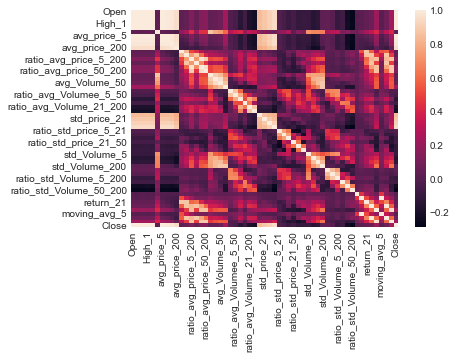

In [13]:
sns.heatmap(data.corr())

# Split the Data Into Training and Testing Datasets

In [37]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(2000, 1, 1,0,0)
end_train = datetime.datetime(2016, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,avg_price_5,avg_price_21,avg_price_50,avg_price_200,...,return_1,return_5,return_21,return_50,return_200,moving_avg_5,moving_avg_21,moving_avg_50,moving_avg_200,Close
count,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1.439000e+03,1439.000000,1439.000000,1439.000000,1439.000000,...,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000
mean,9.556787,9.547930,9.545640,9.716417,9.369572,6.833513e+07,9.527889,9.461842,9.349024,8.709293,...,0.002006,0.009771,0.042638,0.110567,0.598289,0.001970,0.001969,0.001970,0.002079,9.554385
std,6.028134,6.030346,6.027669,6.118639,5.933891,6.233723e+07,6.025417,6.024520,6.026090,5.997739,...,0.031800,0.070634,0.164462,0.322575,1.139082,0.013905,0.007094,0.004942,0.002701,6.025351
min,1.462000,1.462000,1.463333,1.540667,1.433333,3.594000e+06,1.522533,1.582889,1.598653,1.582103,...,-0.193274,-0.248553,-0.337077,-0.379690,-0.379529,-0.054915,-0.018066,-0.009085,-0.002024,1.463333
25%,2.214666,2.211666,2.216333,2.266333,2.174667,2.128050e+07,2.209467,2.171841,2.075407,2.073127,...,-0.013944,-0.032086,-0.064858,-0.089737,-0.019508,-0.006263,-0.002700,-0.001460,0.000274,2.218667
50%,12.236000,12.232667,12.189333,12.428667,11.992000,5.284350e+07,12.263067,11.922508,11.552147,9.710197,...,0.000870,0.006525,0.025017,0.029879,0.150454,0.001525,0.001548,0.001015,0.001164,12.204667
75%,14.788000,14.788000,14.735333,15.007000,14.552000,8.969625e+07,14.801200,14.777921,14.701560,15.121098,...,0.018100,0.050224,0.121457,0.200564,0.448748,0.010188,0.005891,0.004090,0.002507,14.735333
max,19.177999,19.177999,19.069332,19.427999,18.693333,3.391467e+08,18.811333,17.972317,17.420413,15.855690,...,0.243951,0.520703,1.154883,2.126381,4.742338,0.092223,0.039739,0.024566,0.009571,19.069332


In [38]:
#segregate data for validation
start_test = datetime.datetime(2017, 1, 1, 0, 0)
end_test = datetime.datetime(2023, 11, 13, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,avg_price_5,avg_price_21,avg_price_50,avg_price_200,...,return_1,return_5,return_21,return_50,return_200,moving_avg_5,moving_avg_21,moving_avg_50,moving_avg_200,Close
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1.477000e+03,1477.000000,1477.000000,1477.000000,1477.000000,...,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,112.299291,112.183123,112.108866,114.738681,109.374249,1.233341e+08,111.874520,110.789981,108.549596,95.458096,...,0.002496,0.012700,0.057838,0.147942,0.883934,0.002498,0.002614,0.002717,0.002695,112.231902
std,116.373434,116.385452,116.213468,119.054576,113.355736,7.343234e+07,116.102103,115.615335,114.439944,106.327445,...,0.038556,0.089392,0.197613,0.342823,1.575648,0.017520,0.008723,0.005493,0.003452,116.205986
min,12.073333,12.073333,11.931333,12.445333,11.799333,2.940180e+07,12.412133,13.370190,13.056213,14.277557,...,-0.210628,-0.430459,-0.579194,-0.414163,-0.497774,-0.104111,-0.037544,-0.009471,-0.002753,11.931333
25%,20.455334,20.437332,20.500668,20.770666,20.066668,7.280850e+07,20.534666,20.502317,20.523613,20.185600,...,-0.016550,-0.038906,-0.075149,-0.099343,-0.049217,-0.007536,-0.003096,-0.001471,0.000292,20.501333
50%,25.198668,25.111334,25.176001,25.573999,24.673332,9.860550e+07,24.966000,23.962889,23.457853,22.295503,...,0.001611,0.008600,0.035229,0.075783,0.255066,0.002265,0.002061,0.002105,0.001587,25.266001
75%,225.399994,225.399994,224.966660,230.460007,219.836670,1.449732e+08,225.554663,227.426192,227.580333,198.618763,...,0.019823,0.055705,0.152809,0.276551,0.862344,0.011365,0.007418,0.005524,0.003491,224.966660
max,411.470001,411.470001,409.970001,414.496674,405.666656,3.391467e+08,403.096667,373.554125,357.870532,304.789333,...,0.198949,0.564756,1.087066,1.776947,8.767870,0.095850,0.037704,0.021877,0.012733,409.970001


In [39]:
X_train = data_train.drop('Close', axis='columns')
y_train = data_train.Close

X_test = data_test.drop('Close', axis='columns')
y_test = data_test.Close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1439, 55), (1477, 55), (1439,), (1477,))

### SCALING THE PREDICTOR DATA

In [40]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

## LINEAR REGRESSION (LIN)

In [41]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 5.771
MAE: 3.061
R^2: 0.998


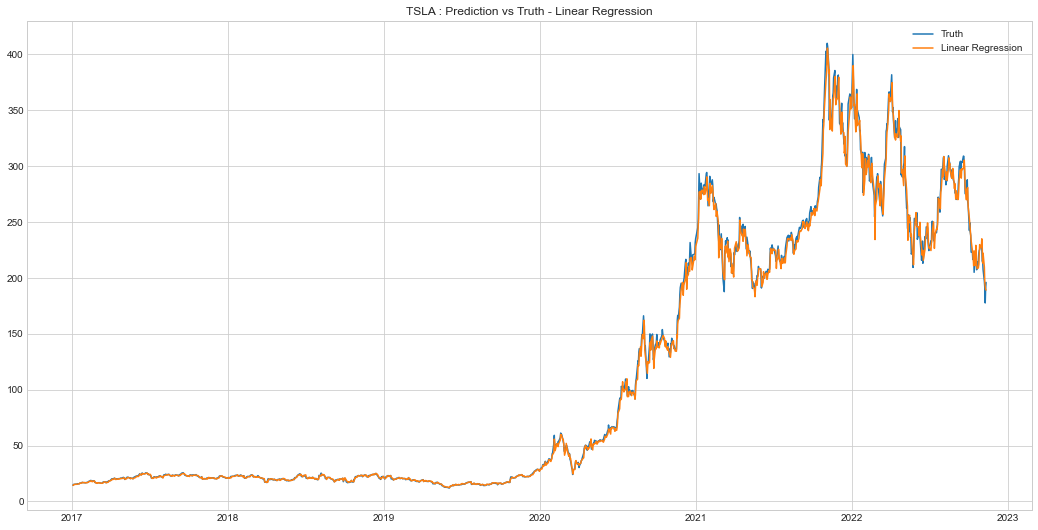

In [42]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title(f'{name} : Prediction vs Truth - Linear Regression')
plt.show()

## SGD REGRESSOR (SGD)

(First experiment with linear regression)

**SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.**

**search for the SGD-based linear regression with the optimal set of parameters.**

In [43]:
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 3e-05, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 7.713
MAE: 4.144
R^2: 0.996


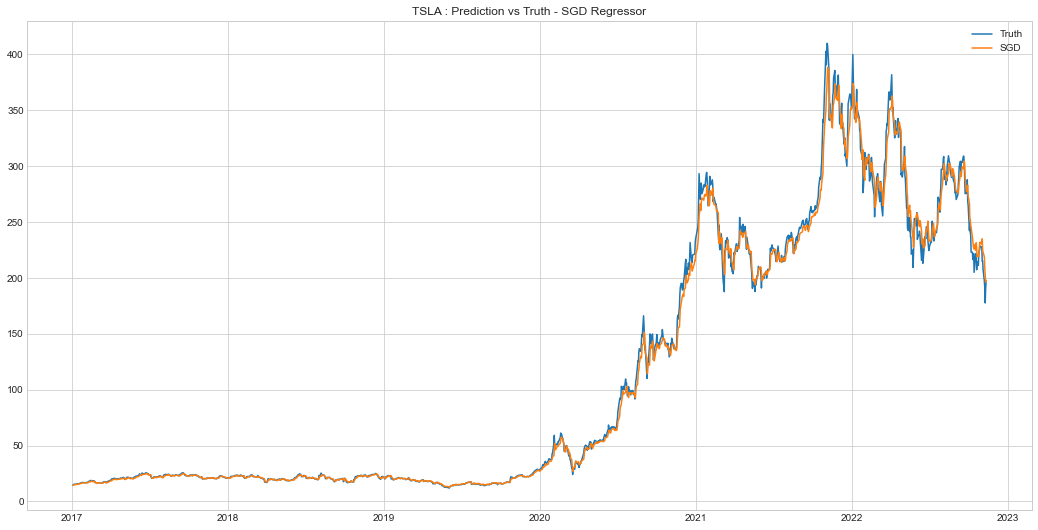

In [44]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title(f'{name} : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

# Extreme Gradient Boosting Regressor (XGB)
Commented out for now due to slowness, code works just slow to run

In [45]:
# xgb = XGBRegressor()

# data_dmatrix = DMatrix(data=X_train,
#                            label=y_train)

# xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
#                   'n_estimators': [50, 100, 200, 300],
#                   'subsample': [0.3, 0.5, 0.7, 1]}

# grid_search = GridSearchCV(estimator=xgb,    
#                         param_grid=xgb_param_grid,
#                         scoring='neg_mean_squared_error', 
#                         cv=4, 
#                         verbose=1,
#                        n_jobs=-1)

# grid_search.fit(X_train, y_train) 

# print("Best parameters found: ",grid_search.best_params_)

# xgb_best = grid_search.best_estimator_

# xgb_best.fit(X_train,y_train)
# predictions_xgb = xgb_best.predict(X_test)

# print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
# print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
# print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

In [46]:
# dates = data_test.index.values
# plt.figure(figsize = (18,9))
# plot_truth, = plt.plot(dates, y_test)
# plot_xgb, = plt.plot(dates, predictions_xgb)
# plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
# plt.title(f'{name} : Prediction vs Truth - XGB Regressor')
# plt.show()

# Bagging-Regressor-(BGR)

In [47]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 5.746
MAE: 3.041
R^2: 0.998


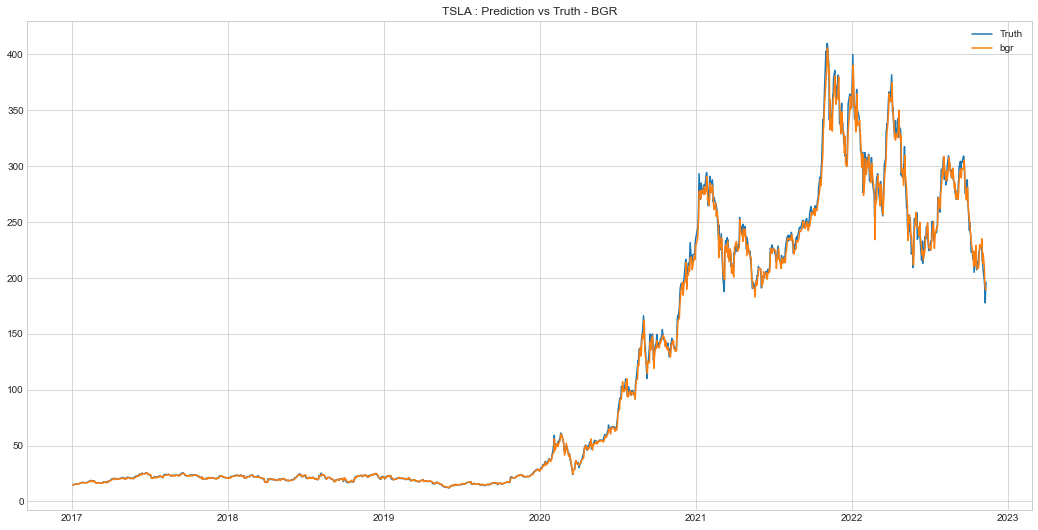

In [48]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title(f'{name} : Prediction vs Truth - BGR')
plt.show()

# Random Forest Regressor (RF)

In [49]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 50, 'min_samples_split': 5}
RMSE: 149.209
MAE: 94.101
R^2: -0.650


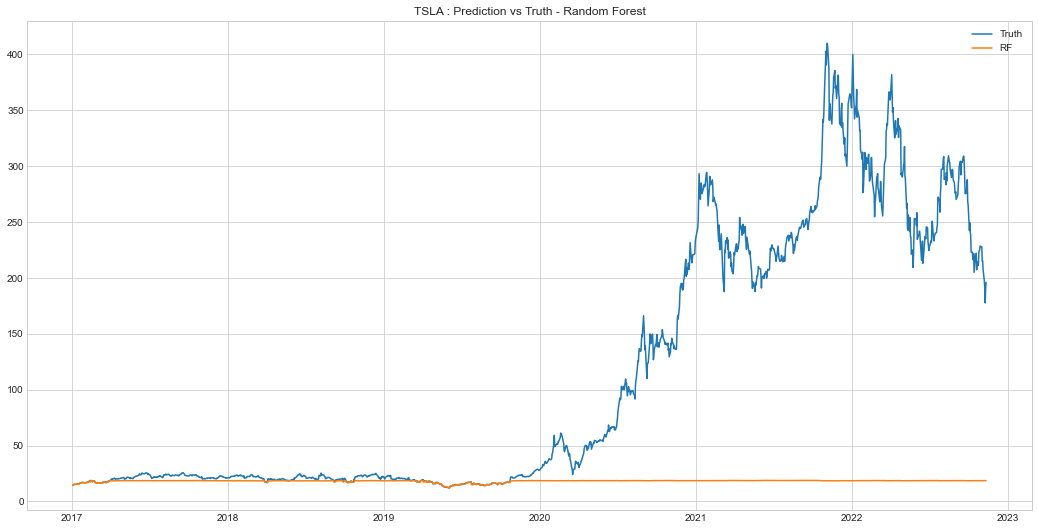

In [50]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title(f'{name} : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 BGR    3.040605
dtype: float64


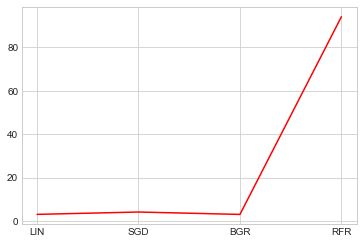

In [51]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                # 'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

## Saving, Loading and Predicting with the BGR Model

In [52]:
#saving the BGR model with joblib
joblib.dump(bgr, f'bgr_{name}.pkl')

['bgr_TSLA.pkl']

In [53]:
#loading the saved model
model = joblib.load(f'bgr_{name}.pkl')

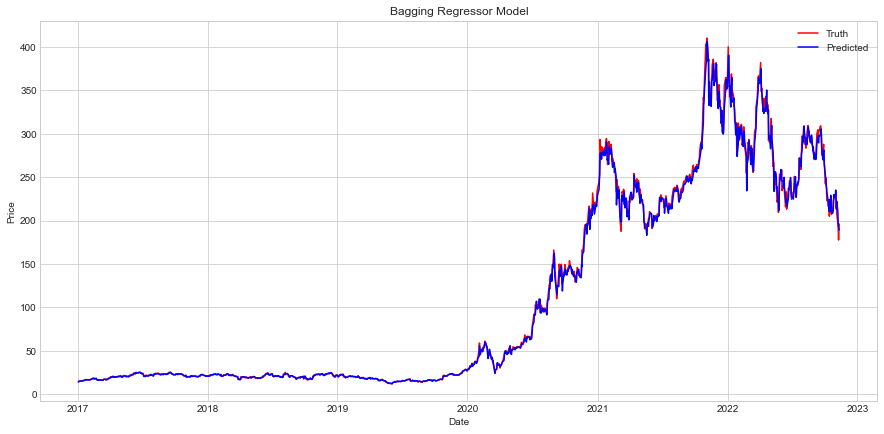

In [54]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

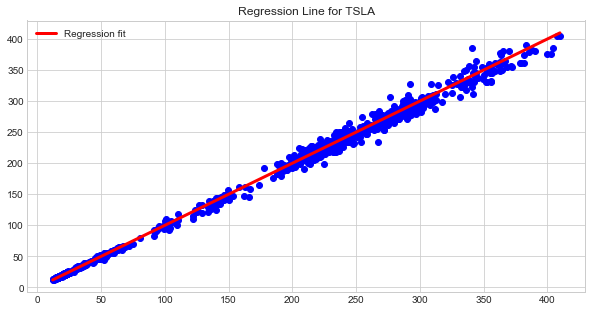

In [55]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title(f"Regression Line for {name}")
plt.legend()
plt.show()